# Hyperparameter Optimization

Hyperparameter optimization is about finding the hyperparameters that produce the best model.

### Key concepts

| <p style="font-size: 17px">Concept</p>      | <p style="font-size: 17px">Description</p> |
| ----------- | ----------- |
| <p style="font-size: 17px">model parameter</p>      | <p style="font-size: 17px">learned through the training algorithm, i.e. `model.fit()`</p>       |
| <p style="font-size: 17px">hyperparameter</p>      | <p style="font-size: 17px">set before the training starts</p>       
| <p style="font-size: 17px">Grid Search</p>      | <p style="font-size: 17px">try every possible combination of hyperparameters and use the combination that produces the best score</p>
| <p style="font-size: 17px">Random Search</p>      | <p style="font-size: 17px">try randomly sampled hyperparameters. More efficient when searching a larger hyperparameter space/p>      
| <p style="font-size: 17px">model selection</p>      | <p style="font-size: 17px">another word for *hyperparameter search*</p>      


## Grid Search in Scikit learn

In [2]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from pprint import pprint

bca = datasets.load_breast_cancer()

X = bca.data[:,:2]  # only two features
y = bca.target

svc = svm.SVC()

grid = GridSearchCV(svc,
        param_grid={'C': [1.0, 0.1, 0.01, 0.001], 'kernel':['linear', 'rbf']},
        scoring='accuracy',
        n_jobs=1,
        cv=None
        )

grid.fit(X, y)
print("all scores      :")
pprint(grid.cv_results_)

print("\nbest score      :", grid.best_score_)

all scores      :
{'mean_fit_time': array([0.00603318, 0.00204101, 0.00210958, 0.00259099, 0.00144939,
       0.00385962, 0.00156541, 0.00389481]),
 'mean_score_time': array([0.00047321, 0.00050774, 0.00036893, 0.00064321, 0.00040541,
       0.00083046, 0.0004324 , 0.00081449]),
 'mean_test_score': array([0.88051545, 0.89632045, 0.87876106, 0.8963515 , 0.88051545,
       0.70131967, 0.86821922, 0.6274181 ]),
 'param_C': masked_array(data=[1.0, 1.0, 0.1, 0.1, 0.01, 0.01, 0.001, 0.001],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf', 'linear', 'rbf',
                   'linear', 'rbf'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'C': 1.0, 'kernel': 'linear'},
            {'C': 1.0, 'kernel': 'rbf'},
            {'C': 0.1, 'kernel': 'linear'},
     

to get an overview of the examined size of the hyperparameter space insepct the fields `grid.cv_results_['mean_test_score']` and `grid.cv_results_['params']`:

In [22]:
grid_mean_test_score = grid.cv_results_['mean_test_score']
grid_mean_test_score

array([0.88051545, 0.89632045, 0.87876106, 0.8963515 , 0.88051545,
       0.70131967, 0.86821922, 0.6274181 ])

In [23]:
grid_params = grid.cv_results_['params']
grid_params

[{'C': 1.0, 'kernel': 'linear'},
 {'C': 1.0, 'kernel': 'rbf'},
 {'C': 0.1, 'kernel': 'linear'},
 {'C': 0.1, 'kernel': 'rbf'},
 {'C': 0.01, 'kernel': 'linear'},
 {'C': 0.01, 'kernel': 'rbf'},
 {'C': 0.001, 'kernel': 'linear'},
 {'C': 0.001, 'kernel': 'rbf'}]

plot them as a heatmap 

In [46]:
import pandas as pd
df = pd.DataFrame.from_dict(grid_params)
df['mean_test_score'] = grid_mean_test_score
##df["grid_params"] = df["C"].astype(str) + ' ' + df["kernel"]
##df = df.drop(columns=['C', 'kernel'])
##df.shape
df

,C,kernel,mean_test_score
0,1.000,linear,0.880515
1,1.000,rbf,0.896320
2,0.100,linear,0.878761
3,0.100,rbf,0.896351
4,0.010,linear,0.880515
5,0.010,rbf,0.701320
6,0.001,linear,0.868219
7,0.001,rbf,0.627418


In [63]:
import pandas as pd
pivot = pd.pivot_table(df, values='mean_test_score', index=['kernel'],
                     columns=['C'], aggfunc=np.sum)
pivot

C,0.001,0.010,0.100,1.000
kernel,,,,
linear,0.868219,0.880515,0.878761,0.880515
rbf,0.627418,0.701320,0.896351,0.896320


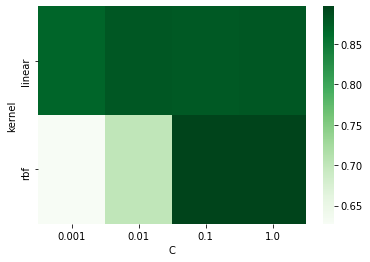

In [74]:
sns.heatmap(pivot, cmap="Greens") # plus any other aesthetic parameters you wish

## Pipelines

Scikit-learn Pipelines bundle multiple modeling/preprocessing steps into one, so that you can use them in cross-validation or hyperparmeter search.

In [75]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

p = make_pipeline(
        MinMaxScaler(),
        LogisticRegression()
      )
p.fit(X, y)
p.score(X, y)

scores = cross_val_score(p, X, y)
print(scores)

[0.83333333 0.96666667 0.93333333 0.9        1.        ]


## Building your own Estimator

Sometimes it is necessary to write code for feature enigneering for which no scikit-learn function exists. If you want to apply such operations to new data, you can write your own **Estimator class** that can be integrated into a pipeline:

In [76]:
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.base import BaseEstimator, TransformerMixin


class FillMissingValues(BaseEstimator, TransformerMixin):

     def __init__(self, strategy='mean'):
         """Store the hyperparameters"""
         self.strategy = strategy

     def fit(self, X):
         self.mean_ = X.mean()
         return self

     def transform(self, X):
         return X.fillna(self.mean_)

     def get_params(self, deep=True):
         """Scikit requires us to return a dictionary here"""
         return {"strategy": self.strategy}

     def set_params(self, **parameters):
         """Scikit uses this to set parameters"""
         for parameter, value in parameters.items():
             setattr(self, parameter, value)
         return self


import pandas as pd
import numpy as np

X = pd.Series([1, 3, np.NaN, 4, 0])
m = FillMissingValues()
m.fit(X)
print(m.transform(X))

# use ClassifierMixin in you want to create your own model
#  (needs to have a predict() method)


0    1.0
1    3.0
2    2.0
3    4.0
4    0.0
dtype: float64


In [17]:
df = pd.read_csv('train.csv')

In [18]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [19]:
X = df[['temp', 'humidity']]
y = df['count']

In [20]:
X.head()

,temp,humidity
0,9.84,81
1,9.02,80
2,9.02,80
3,9.84,75
4,9.84,75


In [21]:
# polynomial feature engineering
from sklearn.preprocessing import PolynomialFeatures # transformative model
# regularization
from sklearn.linear_model import Ridge # predictive model 

In [22]:
from sklearn.pipeline import make_pipeline
# metamodel
# puts different models into a pipeline
# to avoid the doubling of fit transform for train and test data

In [23]:
from sklearn.ensemble import VotingRegressor # bonus combination model you can try out

In [24]:
m = make_pipeline(PolynomialFeatures(), Ridge())
m

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

# FunctionTransformer
you can also take your own custom feature engineering function and wrap it into a sklearn object called a FunctionTransformer, , so that you can also include it in the pipeline

In [25]:
m.fit(X, y) #polynomialfeatures.fit_transform(), followed by ridge.fit()

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

How to choose the optimal combination of hyperparameters?

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
PARAM_GRID = {'polynomialfeatures__degree':[1, 2, 3, 4, 5, 6, 7, 8],
             'ridge__alpha':[0.5, 0.6, 1.0, 2.0, 5.0]}

grid = GridSearchCV(m, param_grid=PARAM_GRID)
# deault scoring method is R2
# but we can customize it to the log ...

In [29]:
grid.fit(X, y)

/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.95603e-20): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.63373e-20): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.58035e-20): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.01999e-20): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.33319e-20): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib

/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.02592e-27): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.74733e-28): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.04058e-27): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.38373e-27): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.30865e-27): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib

/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.10317e-30): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.0356e-30): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.73541e-31): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.06146e-30): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.31982e-35): result may not be accurate.
  overwrite_a=True).T
/Users/lara/anaconda3/lib/

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'polynomialfeatures__degree': [1

In [30]:
grid.best_params_

{'polynomialfeatures__degree': 4, 'ridge__alpha': 5.0}

In [32]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures__degree,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004073,0.000468,0.001753,0.000221,1,0.5,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.589308,-0.135144,0.183403,0.178237,0.029768,-0.066609,0.286236,27
1,0.004468,0.000931,0.001512,0.000178,1,0.6,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.589308,-0.135144,0.183403,0.178237,0.029768,-0.066609,0.286236,26
2,0.003368,0.000237,0.001270,0.000122,1,1,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.589309,-0.135144,0.183403,0.178237,0.029768,-0.066609,0.286236,25
3,0.003339,0.000340,0.001206,0.000153,1,2,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.589310,-0.135142,0.183403,0.178237,0.029767,-0.066609,0.286237,24
4,0.003174,0.000113,0.001354,0.000176,1,5,"{'polynomialfeatures__degree': 1, 'ridge__alph...",-0.589315,-0.135137,0.183403,0.178237,0.029767,-0.066609,0.286238,23
5,0.004185,0.001124,0.001394,0.000216,2,0.5,"{'polynomialfeatures__degree': 2, 'ridge__alph...",-0.370138,-0.076601,0.170387,0.197681,0.057950,-0.004144,0.207003,11
6,0.003449,0.000249,0.001188,0.000022,2,0.6,"{'polynomialfeatures__degree': 2, 'ridge__alph...",-0.370139,-0.076601,0.170389,0.197680,0.057949,-0.004144,0.207004,12
7,0.003743,0.000426,0.001241,0.000074,2,1,"{'polynomialfeatures__degree': 2, 'ridge__alph...",-0.370144,-0.076604,0.170394,0.197679,0.057948,-0.004145,0.207006,13
8,0.003532,0.000219,0.001194,0.000021,2,2,"{'polynomialfeatures__degree': 2, 'ridge__alph...",-0.370157,-0.076610,0.170408,0.197676,0.057945,-0.004147,0.207013,14
9,0.003462,0.000173,0.001277,0.000088,2,5,"{'polynomialfeatures__degree': 2, 'ridge__alph...",-0.370194,-0.076629,0.170449,0.197668,0.057936,-0.004154,0.207032,15


In [33]:
final_model = grid.best_estimator_

In [34]:
final_model.predict(X_test)
# score and predict on the testing data AT THE VERY END

NameError: name 'X_test' is not defined

A Polynomial of Degree 4 on 2 features ('temp', 'humdity'):
    - temp^2*hum
    - temp^3*hum
    - temp^4*hum
    - temp^2*hum^2
    - temp^2*hum^2

### other things you can put into a pipeline:
1. Custom Feature Engineering (e.g. see: FunctionTransformer)
1.1 
2. Scaling
3. PCA
4. Model